## List of tables:
### 1. [Table 1: Differences in answers to background questions](#questions)
### 2. [Table 2: Estimating differences in answers to questions about motivation using OLS](#motivation_ols)
## List of figures:
### 1. [Figure 1: Differences in time spend on intervention screen](#timer_hist)
### 2. [Figure 2: Correlation heatmap for motivational questions ](#heatmap)

#### Imports libraries

In [1]:
import matplotlib.pyplot as plt  # Plotting library
import numpy as np  # Matrix algebra
import os  # File system handling
import datetime # time handling
import pandas as pd  # Dataframe handling
import statsmodels.formula.api as smf  # Regressions analysis

from matplotlib.ticker import FuncFormatter  # Formating graphs
from scipy import stats  # Statistics module
from statsmodels.iolib.summary2 import summary_col  # Regression output table
from statsmodels.stats.multicomp import MultiComparison  # Multi-comparisson tests

#### Set project directory

In [2]:
PROJECT_FOLDER = os.path.dirname(os.path.dirname(os.getcwd()))
FINAL_DATA_FOLDER = os.path.join(PROJECT_FOLDER, 'data', 'final')
TABLES_FOLDER = os.path.join(PROJECT_FOLDER, 'reports', 'tables', 'experiment_2')
FIGURES_FOLDER = os.path.join(PROJECT_FOLDER, 'reports', 'figures', 'experiment_2')

#### Pandas settings

In [3]:
pd.set_option("display.precision", 3)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.max_rows", 25)

#### Set plotting style

In [4]:
plt.style.use('classic')

#### Set plotting properties 

In [5]:
bar_kw = dict(kind='bar', color='0.4', alpha=0.8, lw=0.5, width=0.7)
line_kw = dict(kind='line', lw=1, alpha=1, legend=True)
font_kw = dict(fontsize=11, color='k')
grid_kw = dict(linewidth=1, axis="y", zorder=2, antialiased=True)
x_lab_kw = dict(fontsize=11, labelpad=3)
y_lab_kw = dict(fontsize=11, labelpad=3)
error_kw = dict(elinewidth=2, ecolor='0.15')
legend_kw = dict(frameon=False)
tick_kw = dict(size=5, 
    which='both', 
    direction='out',
    right=False, 
    top=False,
    labelbottom=True
)

#### Retrieving dataframe

In [6]:
DATA = os.path.join(
    FINAL_DATA_FOLDER, 
    'experiment_2', 
    'data_final.feather'
)

df = pd.read_feather(DATA)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1768 entries, 0 to 1767
Columns: 596 entries, Age to Q110_timer
dtypes: datetime64[ns](2), float64(309), int64(26), object(259)
memory usage: 8.0+ MB


#### Define treatment index for ordering

In [7]:
treat_index = ['Neutral', 'Charisma without goal', 'Goal', 'Full charisma']

#### Average time spend to complete survey

In [25]:
duration = df.Duration_survey.mean()
timer = datetime.timedelta(seconds=duration) 
print(f'Workers spend {timer} to complete the survey.')

Workers spend 0:14:18.921946 to complete the survey.


#### Histogram: Time spend on intervention screen  <a id='timer_hist'></a>

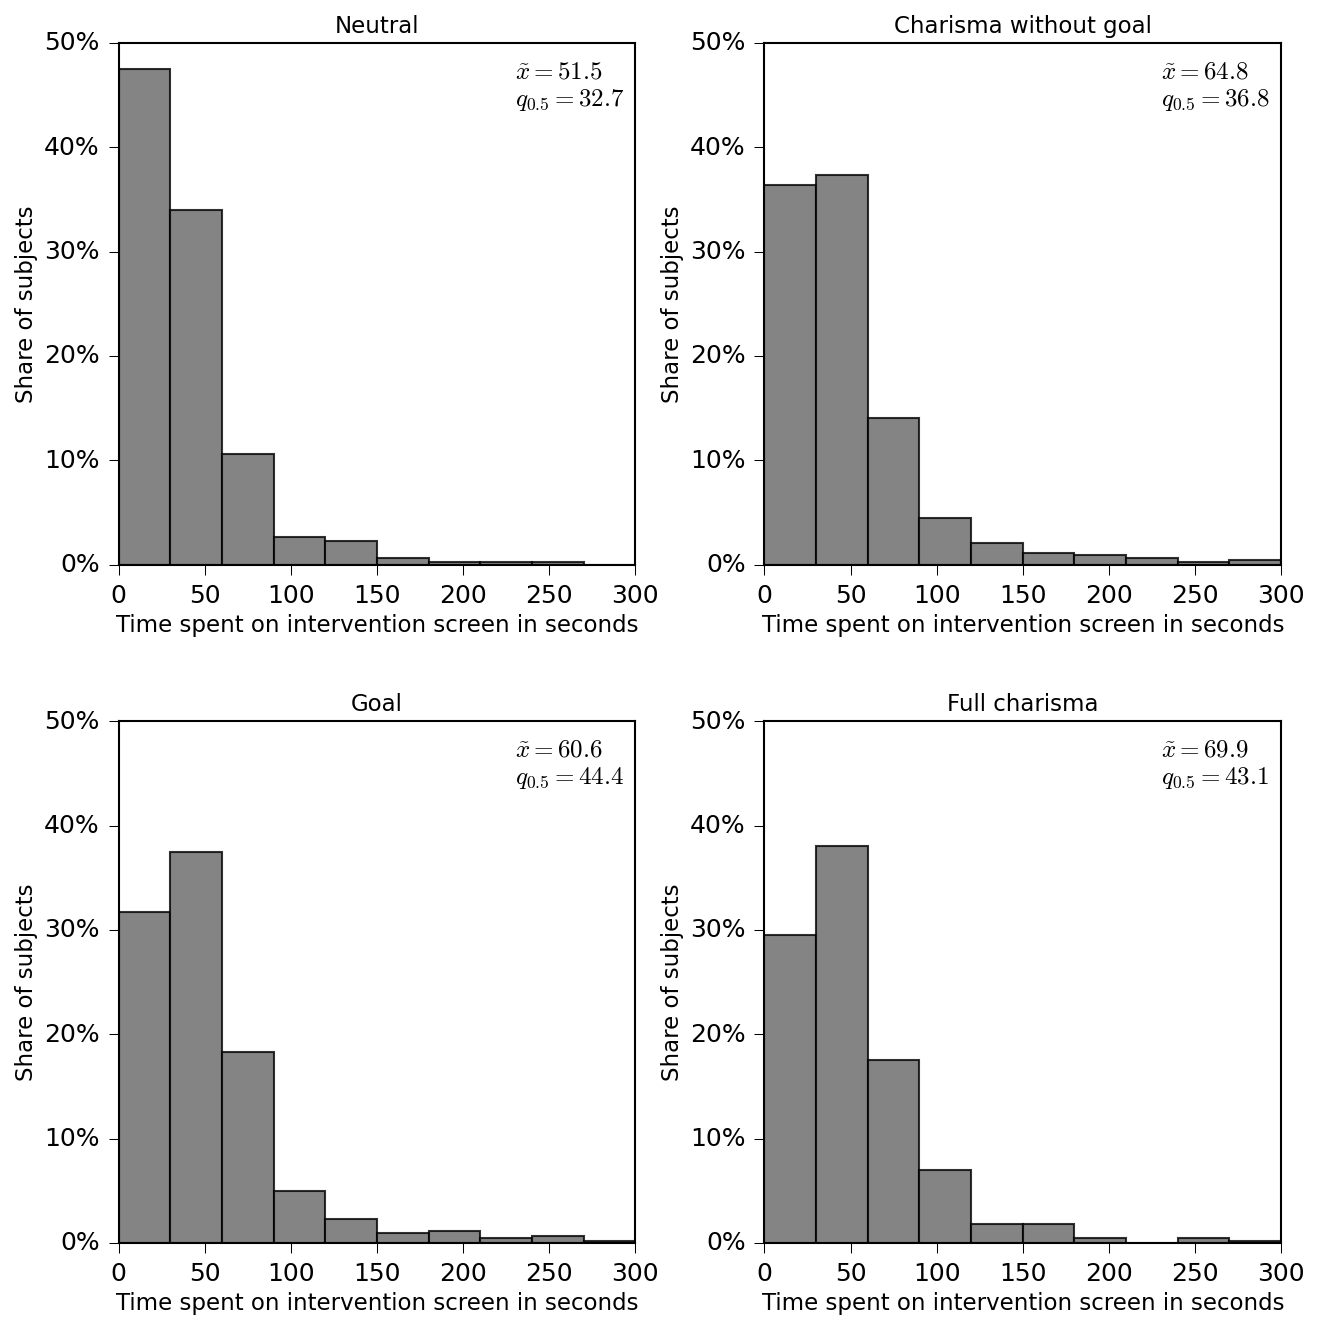

In [9]:
hist_params = dict(bins=10, range=(0, 300), color='0.4', alpha=0.8)
fig, axis = plt.subplots(2, 2, sharey=False, figsize=(10, 10), dpi=150, facecolor='w')
fig.subplots_adjust(hspace=0.30, wspace=0.25)
for i, ax in enumerate(fig.axes):
    timer = df[df['Treatment_str'] == treat_index[i]]['Intervention_timer']
    timer.hist(ax=ax, weights=np.ones(len(timer)) / len(timer), **hist_params)
    ax.set_title(treat_index[i], **font_kw)
    ax.set_ylim(0, 0.5)
    ax.grid(False)
    ax.tick_params(**tick_kw)
    ax.set_xlabel("Time spent on intervention screen in seconds", **x_lab_kw)
    ax.set_ylabel("Share of subjects", **y_lab_kw)
    ax.yaxis.set_major_formatter(FuncFormatter('{:.0%}'.format))
    mean, med = timer.mean(), timer.median()
    ax.text(230, 0.44, f"$\~{{x}}={mean:.1f}$\n$q_{{0.5}}={med:.1f}$")

path = os.path.join(FIGURES_FOLDER, 'intervention_timer_hist_2.pdf')
fig.savefig(path, bbox_inches='tight')

#### Pairwise t-test across treatments for average time spend on intervention screen. 

In [10]:
mct = MultiComparison(df['Intervention_timer'], df['Treatment_str'])
mct.allpairtest(stats.ttest_ind, method='Holm')[0]

group1,group2,stat,pval,pval_corr,reject
Charisma without goal,Full charisma,-0.5354,0.5925,1.0,False
Charisma without goal,Goal,0.5623,0.574,1.0,False
Charisma without goal,Neutral,1.5813,0.1142,0.5708,False
Full charisma,Goal,1.2023,0.2296,0.6887,False
Full charisma,Neutral,2.1446,0.0323,0.1935,False
Goal,Neutral,1.4049,0.1604,0.6417,False


#### Table 1: Differences in answers to questions about motivation <a id='questions'></a>

In [11]:
questions = [
    'Enjoyment', 
    'Motivation', 
    'Identify_mission',
    'Future_motivation', 
    'Frick_knowledge',
] 

balance = pd.pivot_table(
    df, 
    index='Treatment_str' , 
    aggfunc=['mean', 'sem'], 
    values=questions, margins=True
    )\
    .rename({'mean':'Mean', 'sem':'Se'}, level=0, axis=1)\
    .rename_axis('Treatment')\
    .reindex(questions, axis=1, level=1)\
    .rename(lambda x: x.replace('_', ' '), level=1, axis=1)\
    .swaplevel(axis=1)\
    .sort_index(axis=1, level=0)\
    .reindex(treat_index)\
    
balance.to_latex(
    os.path.join(TABLES_FOLDER, 'questions_table.tex'),
    bold_rows=True,
    float_format="%.2f"
)

balance

Enjoyment        Frick knowledge        Future motivation        Identify mission        Motivation       
                           Mean     Se            Mean     Se              Mean     Se             Mean     Se       Mean     Se
Treatment                                                                                                                       
Neutral                   3.836  0.052           1.165  0.039             4.694  0.029            2.761  0.059      4.509  0.037
Charisma without goal     3.903  0.050           1.204  0.038             4.717  0.029            2.962  0.056      4.514  0.036
Goal                      3.788  0.050           1.219  0.040             4.646  0.033            2.984  0.052      4.507  0.036
Full charisma             3.878  0.051           1.160  0.040             4.694  0.032            2.914  0.055      4.547  0.035

#### Estimating differences in answers for questions about motivation using OLS  <a id='motivation_ols'></a>

In [12]:
ols_results = [
    smf.ols(formula=f'{variable} ~ C(Treatment)', data=df).fit(cov_type='HC1')
    for variable in questions
]

auxiliary = {
    'N': lambda x: f'{x.nobs:.0f}',
    'F': lambda x: f'{x.fvalue:.3f}',
    'P(>F)': lambda x: f'{x.f_pvalue:.3f}',
}

ols_balance = summary_col(
    ols_results,
    stars=True,
    info_dict=auxiliary,
    float_format='%.3f'
)

label_index = {
    'Intercept': 'Constant',
    '2': 'Charisma without Goal',
    '3': 'Goal',
    '4': 'Full charisma'
}
ols_balance = ols_balance.tables[0]\
    .rename(mapper=lambda x: x.replace('C(Treatment)[T.', '').replace(']', ''), axis=0)\
    .rename(mapper=lambda x: x.replace('_',' '), axis=1)\
    .rename(label_index, axis=0)\
    .rename_axis('Dependent variable:', axis=1)

ols_balance.to_latex(
    os.path.join(TABLES_FOLDER, 'ols_questions.tex'),
    bold_rows=True,
    float_format="%.3f"
)

ols_balance

Dependent variable:,Enjoyment,Motivation,Identify mission,Future motivation,Frick knowledge
Constant,3.836***,4.509***,2.761***,4.694***,1.165***
,(0.052),(0.037),(0.059),(0.029),(0.039)
Charisma without Goal,0.067,0.005,0.200**,0.024,0.039
,(0.072),(0.052),(0.082),(0.041),(0.055)
Goal,-0.048,-0.002,0.223***,-0.048,0.054
,(0.072),(0.051),(0.079),(0.044),(0.056)
Full charisma,0.043,0.038,0.153*,0.000,-0.005
,(0.073),(0.051),(0.081),(0.043),(0.056)
R-squared,0.002,0.000,0.005,0.002,0.001
R-squared Adj.,-0.000,-0.001,0.004,-0.000,-0.001


#### Pairwise comparison for the 'Do you Identify with the mission' question

In [13]:
mct = MultiComparison(df['Identify_mission'], df['Treatment_str'])
mct.allpairtest(stats.ttest_ind, method='Holm')[0]

group1,group2,stat,pval,pval_corr,reject
Charisma without goal,Full charisma,0.5987,0.5495,1.0,False
Charisma without goal,Goal,-0.2927,0.7698,1.0,False
Charisma without goal,Neutral,2.4532,0.0144,0.0718,False
Full charisma,Goal,-0.9147,0.3606,1.0,False
Full charisma,Neutral,1.8916,0.0589,0.2355,False
Goal,Neutral,2.8143,0.005,0.03,True


#### Correlation heatmap for motivational questions <a id='heatmap'></a>

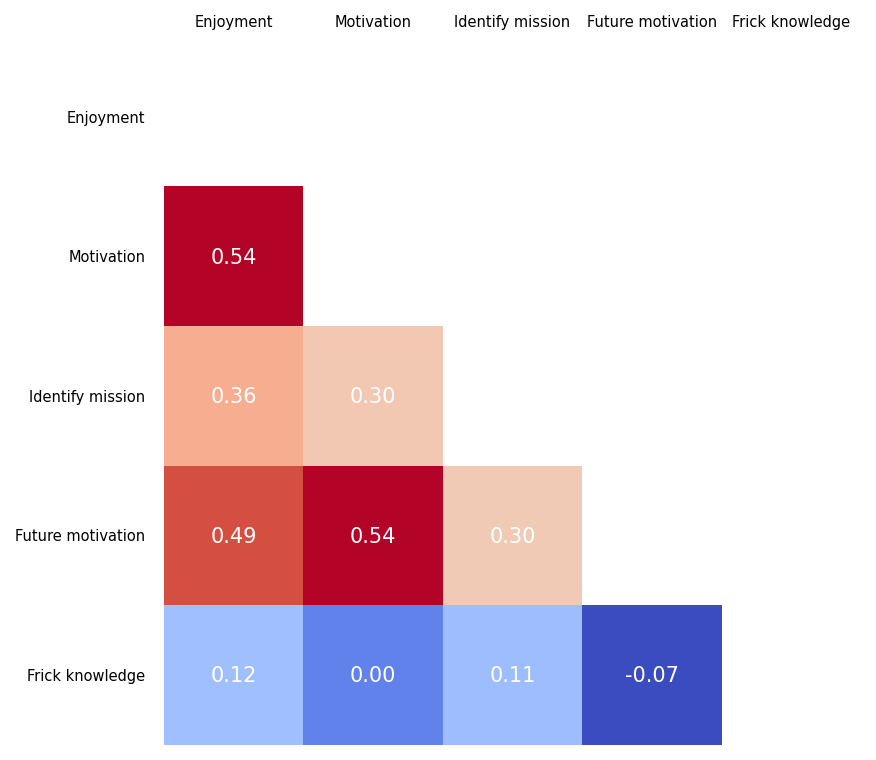

In [14]:
df_corr = df[questions].dropna().corr()
df_corr = df_corr.mask(np.triu(np.ones_like(df_corr, dtype=bool)))\
    .rename(lambda x:x.replace('_', ' '))\
    .rename(lambda x:x.replace('_', ' '), axis=1)

with plt.style.context('classic'):
    fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
    fig.set_facecolor('w')
    ax.matshow(df_corr, cmap='coolwarm')
    ax.tick_params(axis='x', labelsize=7, **tick_kw)
    ax.tick_params(axis='y', labelsize=7, **tick_kw)
    ax.set_xticks(range(len(df_corr.columns)))
    ax.set_yticks(range(len(df_corr.columns)))
    ax.set_xticklabels(df_corr)
    ax.set_yticklabels(df_corr)
    ax.set_frame_on(False)
    ax.tick_params(
        top=False,
        bottom=False,
        left=False,
        right=False,
        labeltop=True,
        labelbottom=False
    )

    for i in range(len(df_corr.columns)):
        for j in range(len(df_corr.columns)):
            text = ax.text(
                j,
                i,
                f'{df_corr.iloc[i,j]:.2f}',
                ha="center",
                va="center",
                color="w",
                size=10,
            )
    fig.tight_layout()

#### Convert to html

In [15]:
!jupyter nbconvert --output-dir='./docs' --to html 3_intervention_timer_and_background_questions.ipynb

[NbConvertApp] Converting notebook 3_intervention_timer_and_background_questions.ipynb to html
[NbConvertApp] Writing 801419 bytes to docs/3_intervention_timer_and_background_questions.html
